In [5]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import warnings
from math import sqrt
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from fbprophet import Prophet
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import statsmodels.tsa.api as smt

In [6]:
print(np.__version__)

1.18.5


In [72]:
print(keras.__version__)

2.5.0


In [7]:
zillow = pd.read_csv('zillow-carlifornia.csv', index_col=[0])
zillow.head()

,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
Date,,,
2008-02-29,470000.0,5.29,6.3
2008-03-31,441000.0,5.44,6.2
2008-04-30,460000.0,5.42,6.4
2008-05-31,429000.0,5.47,6.3
2008-06-30,437500.0,5.60,6.2


In [8]:
zillow.rename(columns = {'MedianSoldPrice_AllHomes.California':'Median_Sale_Price'})

,Median_Sale_Price,MedianMortageRate,UnemploymentRate
Date,,,
2008-02-29,470000.0,5.29,6.3
2008-03-31,441000.0,5.44,6.2
2008-04-30,460000.0,5.42,6.4
2008-05-31,429000.0,5.47,6.3
2008-06-30,437500.0,5.60,6.2
...,...,...,...
2016-08-31,NaN,3.46,4.8
2016-09-30,NaN,3.42,5.0
2016-10-31,NaN,3.36,5.0


In [9]:
df = zillow[:'2015-12-31']

In [10]:
df.tail()

,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
Date,,,
2015-08-31,475000.0,3.95,5.2
2015-09-30,470000.0,3.87,5.1
2015-10-31,470000.0,3.80,5.0
2015-11-30,485750.0,3.69,5.0
2015-12-31,485000.0,3.89,5.1


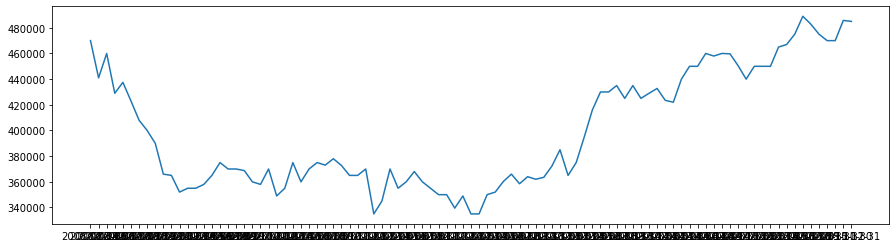

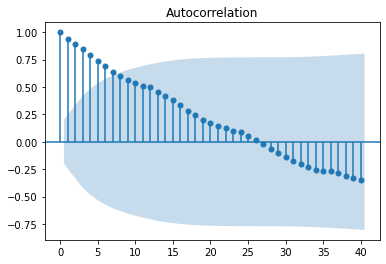

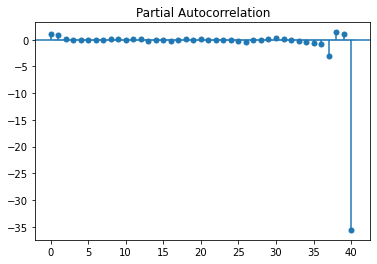

In [11]:
df = pd.read_csv('zillow-carlifornia.csv', index_col='Date')
df = df[:'2015-12-31']
series = df['MedianSoldPrice_AllHomes.California']
x=np.array(series)
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)
ax.plot(series)
plt.show()
plot_acf(series,lags=40) 
plt.show()
plot_pacf(series,lags=40) 
plt.show()


## Univariate Analysis

### SARIMA

In [12]:
dftest = adfuller(series)
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
print (dfoutput)

Test Statistic   -0.058792
p-value           0.953391
dtype: float64


In [13]:
def diff(data, interval=1):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return diff
#trend differencing

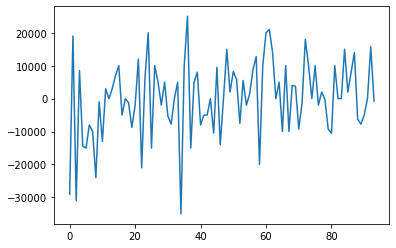

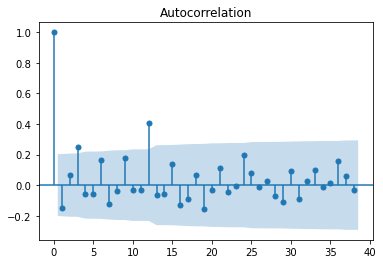

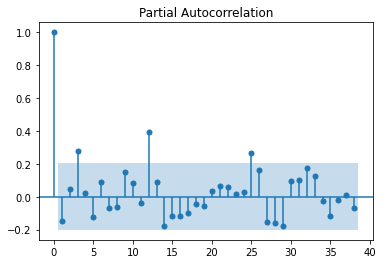

In [14]:
d1 = diff(series, 1)
plt.plot(d1)
plot_acf(d1,lags=38) 
plt.show()
plot_pacf(d1,lags=38) 
plt.show()
#flat already

In [15]:
dftest = adfuller(d1)
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
print (dfoutput)

Test Statistic   -3.088139
p-value           0.027443
dtype: float64


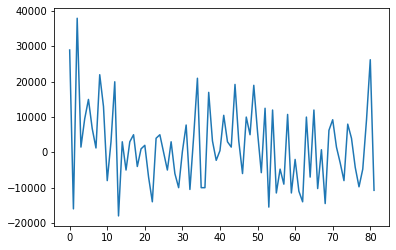

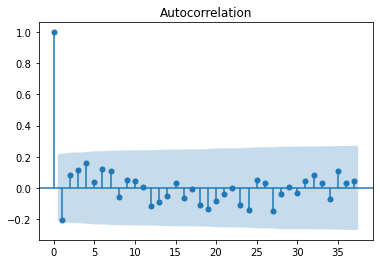

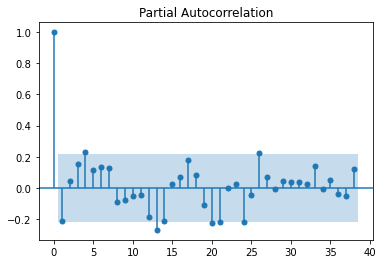

Test Statistic   -1.137508e+01
p-value           8.786119e-21
dtype: float64


In [16]:
#if differencing for one more time
d2 = diff(d1, 12)
plt.plot(d2)
plot_acf(d2,lags=37) 
plt.show()
plot_pacf(d2,lags=38) 
plt.show()
dftest = adfuller(d2)
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
print (dfoutput)

In [17]:
y_train = df['MedianSoldPrice_AllHomes.California']

In [18]:
series

Date
2008-02-29    470000.0
2008-03-31    441000.0
2008-04-30    460000.0
2008-05-31    429000.0
2008-06-30    437500.0
                ...   
2015-08-31    475000.0
2015-09-30    470000.0
2015-10-31    470000.0
2015-11-30    485750.0
2015-12-31    485000.0
Name: MedianSoldPrice_AllHomes.California, Length: 95, dtype: float64

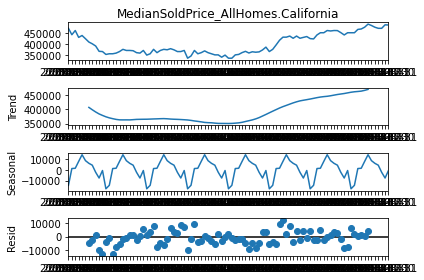

In [19]:
# Decompose to check trend and seasonality
%matplotlib inline
res = sm.tsa.seasonal_decompose(series,freq=12,model="additive")
fig = res.plot()
plt.show()

In [20]:
sarima_house = pm.auto_arima(y_train,
                           information_criterion = 'bic',
                           out_of_sample_size=int(len(df)*0.2),
                           test='adf',
                           start_p=1, start_q=1,
                           max_p=5, max_q=5, m=7,
                           max_P=5, max_Q=5,
                           seasonal=True,
                           d=1, max_d=2,
                           D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

Performing stepwise search to minimize bic
 ARIMA(1,1,1)(1,1,1)[7]             : BIC=inf, Time=0.54 sec
 ARIMA(0,1,0)(0,1,0)[7]             : BIC=1944.572, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[7]             : BIC=1946.383, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[7]             : BIC=1945.388, Time=0.08 sec
 ARIMA(0,1,0)(1,1,0)[7]             : BIC=1946.093, Time=0.10 sec
 ARIMA(0,1,0)(0,1,1)[7]             : BIC=1943.119, Time=0.06 sec
 ARIMA(0,1,0)(1,1,1)[7]             : BIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,1,2)[7]             : BIC=1946.475, Time=0.21 sec
 ARIMA(0,1,0)(1,1,2)[7]             : BIC=inf, Time=0.37 sec
 ARIMA(1,1,0)(0,1,1)[7]             : BIC=1945.833, Time=0.08 sec
 ARIMA(1,1,1)(0,1,1)[7]             : BIC=1945.962, Time=0.19 sec
 ARIMA(0,1,0)(0,1,1)[7] intercept   : BIC=1948.812, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,1,1)[7]          
Total fit time: 2.051 seconds


In [21]:
sarima_house = pm.auto_arima(y_train,
                           information_criterion = 'bic',
                           out_of_sample_size=int(len(df)*0.1),
                           test='adf',
                           start_p=1, start_q=1,
                           max_p=5, max_q=5, m=12,
                           max_P=5, max_Q=5,
                           seasonal=True,
                           d=1, max_d=12,
                           D=2, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

Performing stepwise search to minimize bic
 ARIMA(1,1,1)(1,2,1)[12]             : BIC=1534.936, Time=0.50 sec
 ARIMA(0,1,0)(0,2,0)[12]             : BIC=1559.381, Time=0.05 sec
 ARIMA(1,1,0)(1,2,0)[12]             : BIC=1564.406, Time=0.19 sec
 ARIMA(0,1,1)(0,2,1)[12]             : BIC=1527.654, Time=0.25 sec
 ARIMA(0,1,1)(0,2,0)[12]             : BIC=1562.472, Time=0.07 sec
 ARIMA(0,1,1)(1,2,1)[12]             : BIC=1530.830, Time=0.35 sec
 ARIMA(0,1,1)(0,2,2)[12]             : BIC=1530.353, Time=0.65 sec
 ARIMA(0,1,1)(1,2,0)[12]             : BIC=1564.541, Time=0.18 sec
 ARIMA(0,1,1)(1,2,2)[12]             : BIC=inf, Time=1.37 sec
 ARIMA(0,1,0)(0,2,1)[12]             : BIC=inf, Time=0.34 sec
 ARIMA(1,1,1)(0,2,1)[12]             : BIC=1531.874, Time=0.32 sec
 ARIMA(0,1,2)(0,2,1)[12]             : BIC=1533.075, Time=0.29 sec
 ARIMA(1,1,0)(0,2,1)[12]             : BIC=inf, Time=0.57 sec
 ARIMA(1,1,2)(0,2,1)[12]             : BIC=1536.619, Time=0.47 sec
 ARIMA(0,1,1)(0,2,1)[12] intercept

In [22]:
sarima_house = pm.auto_arima(y_train,
                           information_criterion = 'bic',
                           out_of_sample_size=int(len(df)*0.1),
                           test='adf',
                           start_p=1, start_q=1,
                           max_p=5, max_q=5, m=12,
                           max_P=5, max_Q=5,
                           seasonal=True,
                           d=0, max_d=12,
                           D=2, trace=True,
                           error_action='ignore',
                           with_intercept=True,
                           suppress_warnings=True,
                           stepwise=True)

Performing stepwise search to minimize bic
 ARIMA(1,0,1)(1,2,1)[12] intercept   : BIC=1561.874, Time=0.77 sec
 ARIMA(0,0,0)(0,2,0)[12] intercept   : BIC=1714.730, Time=0.05 sec
 ARIMA(1,0,0)(1,2,0)[12] intercept   : BIC=1731.394, Time=0.46 sec
 ARIMA(0,0,1)(0,2,1)[12] intercept   : BIC=1672.931, Time=0.61 sec
 ARIMA(0,0,0)(0,2,0)[12]             : BIC=1718.386, Time=0.03 sec
 ARIMA(1,0,1)(0,2,1)[12] intercept   : BIC=inf, Time=1.30 sec
 ARIMA(1,0,1)(1,2,0)[12] intercept   : BIC=1737.245, Time=0.48 sec
 ARIMA(1,0,1)(2,2,1)[12] intercept   : BIC=1565.253, Time=2.24 sec
 ARIMA(1,0,1)(1,2,2)[12] intercept   : BIC=inf, Time=2.16 sec
 ARIMA(1,0,1)(0,2,0)[12] intercept   : BIC=1667.304, Time=0.60 sec
 ARIMA(1,0,1)(0,2,2)[12] intercept   : BIC=1561.925, Time=0.85 sec
 ARIMA(1,0,1)(2,2,0)[12] intercept   : BIC=1620.810, Time=0.83 sec
 ARIMA(1,0,1)(2,2,2)[12] intercept   : BIC=1566.352, Time=2.30 sec
 ARIMA(0,0,1)(1,2,1)[12] intercept   : BIC=1686.502, Time=1.14 sec
 ARIMA(1,0,0)(1,2,1)[12] inte

In [23]:
#model evaluation based on RMSE and one-step cross validation
def rmse_sarima(X, trend_order, seasonal_order, split_size): #added split_size
    train_size = int(len(X) * split_size)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = sm.tsa.statespace.SARIMAX(history, order=trend_order,seasonal_order=seasonal_order)
        res = model.fit()
        yhat = res.predict(start=len(history), end=len(history)) #predict one step
        predictions.append(yhat) #store prediction
        history.append(test[t]) #store observation
        # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [24]:
split_size=0.67
X=df['MedianSoldPrice_AllHomes.California']

sarima_rmse1=rmse_sarima(X, (2,1,2), (0,1,0,12), split_size)
sarima_rmse2=rmse_sarima(X, (1,0,0), (0,2,2,12), split_size)
sarima_rmse3=rmse_sarima(X, (0,1,1), (0,2,1,12), split_size)
sarima_rmse4=rmse_sarima(X, (1,0,1), (0,2,1,12), split_size)

In [25]:
print(sarima_rmse1) # Sarima Choice
print(sarima_rmse2)
print(sarima_rmse3)
print(sarima_rmse4)

9945.05743566994
11080.336434490742
12751.057628041412
10934.825700116724


### ETS

In [26]:
def evaluate_es_model(X,Trend, Seasonal,m,damped):
    train_size = int(len(X) * 0.90)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ExponentialSmoothing(history, trend=Trend,seasonal=Seasonal,seasonal_periods=m, damped=damped)
        res = model.fit()
        yhat = res.forecast()[0] #predict one step
        predictions.append(yhat) #store prediction
        history.append(test[t]) #store observation
        # calculate out of sample error
    rmse = mean_squared_error(test, predictions, squared=False)
    return rmse

In [91]:
X=np.array(df['MedianSoldPrice_AllHomes.California'])+1 # adding 1 to avoide 0 consumption
ets_rmse_1=evaluate_es_model(X, Trend="additive", Seasonal="additive",m=12,damped=True)
ets_rmse_2=evaluate_es_model(X, Trend="multiplicative", Seasonal="additive",m=12,damped=True)
ets_rmse_3=evaluate_es_model(X, Trend="additive", Seasonal="multiplicative",m=12,damped=True)
ets_rmse_4=evaluate_es_model(X, Trend="multiplicative", Seasonal="multiplicative",m=12,damped=True)
ets_rmse_5=evaluate_es_model(X, Trend=None, Seasonal="additive",m=12,damped=False)
ets_rmse_6=evaluate_es_model(X, Trend=None, Seasonal="multiplicative",m=12,damped=False)
ets_rmse_7=evaluate_es_model(X, Trend="multiplicative", Seasonal="multiplicative",m=12,damped=False)

In [92]:
print(ets_rmse_1)
print(ets_rmse_2)
print(ets_rmse_3) # best - now! 
print(ets_rmse_4) # best - before!
print(ets_rmse_5) 
print(ets_rmse_6)
print(ets_rmse_7)

9405.877290838258
9423.423145932229
9224.38980666362
1.6845552338904464e+53
9737.829030929199
9534.832017902767
9550.564293915997


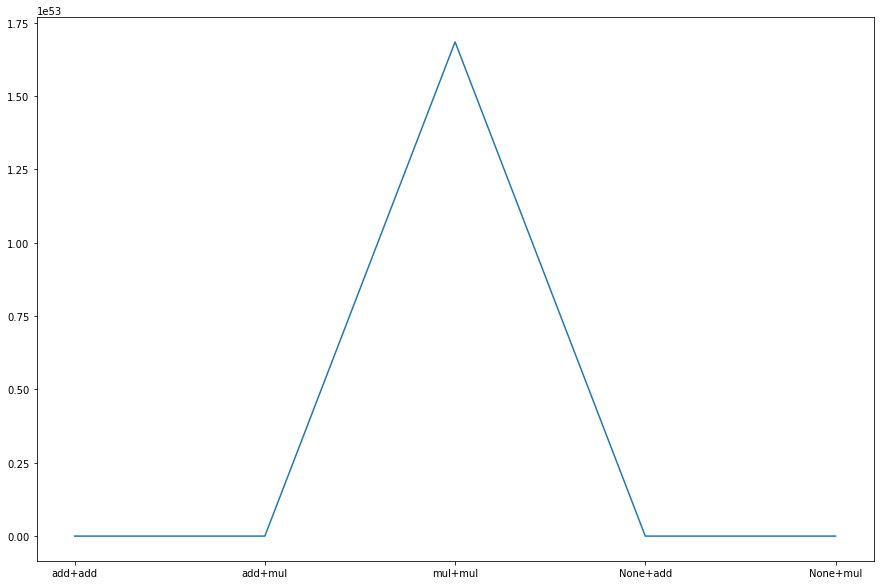

In [29]:
data = {'add+add': ets_rmse_1, 'add+mul': ets_rmse_2, 'mul+mul': ets_rmse_4,'None+add': ets_rmse_5,'None+mul': ets_rmse_6}
models = list(data.keys())
rmse = list(data.values())
plt.figure(figsize=(15, 10))
plt.plot(models, rmse)

### Prophet

In [30]:
df['ds'] = df.index
dt = df[['ds','MedianSoldPrice_AllHomes.California']]
dt=dt.rename(columns={"MedianSoldPrice_AllHomes.California": "y"})
dt.tail()

,ds,y
Date,,
2015-08-31,2015-08-31,475000.0
2015-09-30,2015-09-30,470000.0
2015-10-31,2015-10-31,470000.0
2015-11-30,2015-11-30,485750.0
2015-12-31,2015-12-31,485000.0


In [31]:
prediction_size = 12
train_df = dt[:-prediction_size]
val_df = dt[-prediction_size:]
# train_df.head()
train_df.tail()

,ds,y
Date,,
2014-08-31,2014-08-31,460000.0
2014-09-30,2014-09-30,459750.0
2014-10-31,2014-10-31,450500.0
2014-11-30,2014-11-30,440000.0
2014-12-31,2014-12-31,450000.0


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


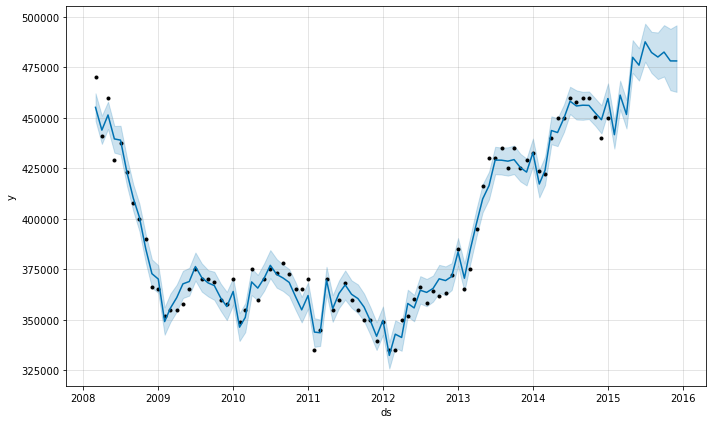

In [32]:
#m = Prophet(seasonality_mode='multiplicative')
m = Prophet()
m.fit(train_df)

future = m.make_future_dataframe(periods=prediction_size, freq='MS')
forecast = m.predict(future)

m.plot(forecast).show()

In [33]:
pred = forecast["yhat"][train_df.shape[0]:]

In [34]:
prophet_rmse = mean_squared_error(val_df['y'], pred, squared=False)
print(prophet_rmse)

9328.918598900007


### LSTM

In [35]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        return agg

In [36]:
values = df['MedianSoldPrice_AllHomes.California'].values.reshape(-1, 1)
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1) 
#print(reframed.head())
values = reframed.values
period=12
train = values[:-period, :]
test = values[-period:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(10, input_shape=(train_X.shape[1], train_X.shape[2]))) # the 4 is the number of hidden layers/neurons, proportional to the sample size
model.add(Dense(1)) #final fully-connected (dense) layer, optional
model.compile(loss='mse')
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=7, validation_data=(test_X, test_y))

Epoch 1/200
12/12 [==============================] - 16s 68ms/step - loss: 0.1233 - val_loss: 0.5695
Epoch 2/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0869 - val_loss: 0.5095
Epoch 3/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0941 - val_loss: 0.4579
Epoch 4/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0737 - val_loss: 0.4072
Epoch 5/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0832 - val_loss: 0.3638
Epoch 6/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0476 - val_loss: 0.3204
Epoch 7/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0538 - val_loss: 0.2796
Epoch 8/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0397 - val_loss: 0.2418
Epoch 9/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0402 - val_loss: 0.2102
Epoch 10/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0371 - val_loss: 0.1829
Epoch 1

In [37]:
from numpy import concatenate

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

lstm_rmse = mean_squared_error(np.array(inv_y), np.array(inv_yhat),squared=False)
print(lstm_rmse)

10019.13769098383


In [73]:
print(f'SARIMA:  {sarima_rmse1:.4f}')
print(f'ETS:     {ets_rmse_3:.4f}')
print(f'Prophet: {prophet_rmse:.4f}') #deepnote issue, should be 9060.8
print(f'LSTM:    {lstm_rmse:.4f}')

SARIMA:  9945.0574
ETS:     9224.3898
Prophet: 9328.9186
LSTM:    10019.1377


### Multivariate Analysis

In [39]:
from statsmodels.tsa.api import VAR

In [40]:
zillow = pd.read_csv('zillow-carlifornia.csv', index_col=[0])
df = zillow[:'2015-12-31']

In [41]:
df_diff = df.diff().dropna()

In [42]:
df_diff

,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
Date,,,
2008-03-31,-29000.0,0.15,-0.1
2008-04-30,19000.0,-0.02,0.2
2008-05-31,-31000.0,0.05,-0.1
2008-06-30,8500.0,0.13,-0.1
2008-07-31,-14500.0,0.31,-0.6
...,...,...,...
2015-08-31,-7750.0,0.08,-0.1
2015-09-30,-5000.0,-0.08,-0.1
2015-10-31,0.0,-0.07,-0.1


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


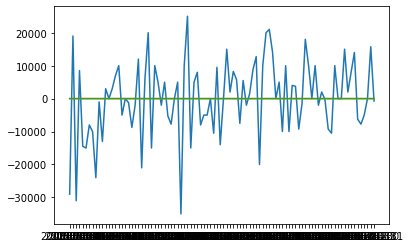

In [43]:
plt.plot(df_diff)
plt.show()

In [44]:
model = VAR(df_diff)
results = model.fit(maxlags=15, ic='bic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 12, Jun, 2021
Time:                     17:37:54
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    14.1741
Nobs:                     94.0000    HQIC:                   14.1257
Log likelihood:          -1059.51    FPE:                1.31969e+06
AIC:                      14.0929    Det(Omega_mle):     1.27845e+06
--------------------------------------------------------------------
Results for equation MedianSoldPrice_AllHomes.California
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const       159.574468      1194.380592            0.134           0.894

Results for equation MedianMortageRate
           coefficient       std. error           t-stat            prob
----------------------

In [45]:
model = VAR(df)
results = model.fit(maxlags=15, ic='bic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 12, Jun, 2021
Time:                     17:37:54
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    14.1471
Nobs:                     94.0000    HQIC:                   13.9536
Log likelihood:          -1037.80    FPE:                1.00710e+06
AIC:                      13.8224    Det(Omega_mle):         888750.
--------------------------------------------------------------------
Results for equation MedianSoldPrice_AllHomes.California
                                            coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------------------
const                                      28600.710790     23166.335094            1.235           0.217
L1.MedianSoldPrice_AllHomes.Californ

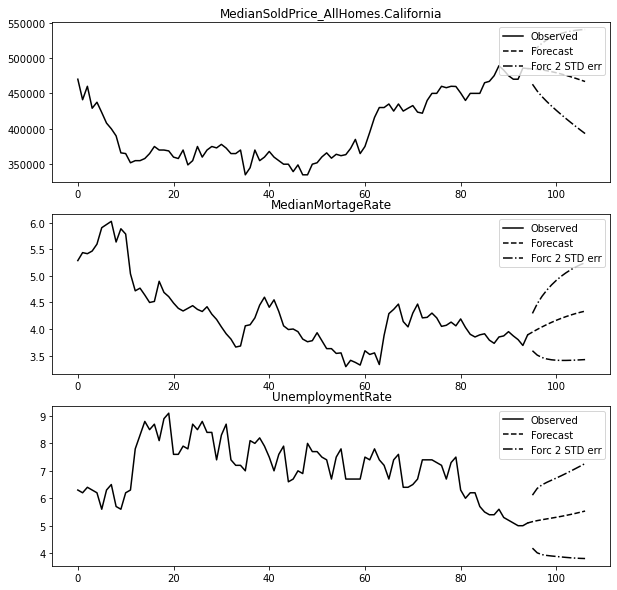

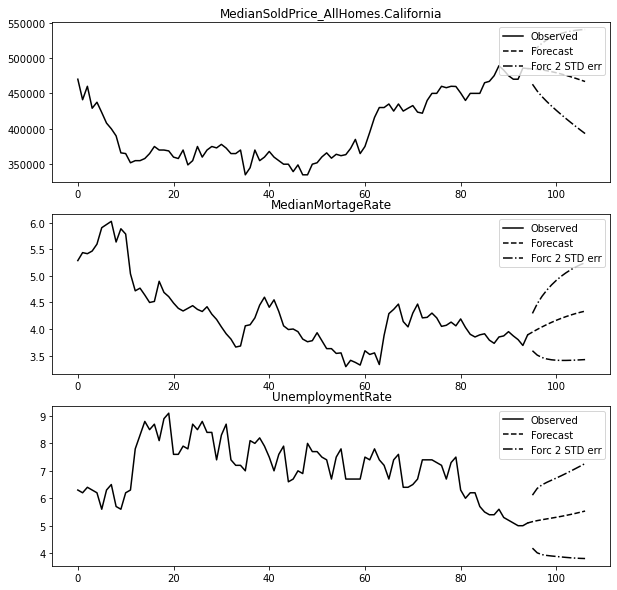

In [46]:
results.plot_forecast(12)

In [47]:
zillow = pd.read_csv('zillow-carlifornia.csv', index_col=[0])
df = zillow[:'2015-12-31']

In [48]:
df['ds'] = df.index

In [49]:
df=df.rename(columns={"MedianSoldPrice_AllHomes.California":"y"})

In [50]:
dt = df[['ds','y','UnemploymentRate']].dropna()
dt2 = df[['ds','y','MedianMortageRate']].dropna()
dt3 = df[['ds','y','MedianMortageRate', 'UnemploymentRate']].dropna()

In [51]:
prediction_size = 12
train_df = dt2[:-prediction_size]
val_df = dt2[-prediction_size:]
# train_df.head()
train_df.tail()

,ds,y,MedianMortageRate
Date,,,
2014-08-31,2014-08-31,460000.0,4.13
2014-09-30,2014-09-30,459750.0,4.06
2014-10-31,2014-10-31,450500.0,4.19
2014-11-30,2014-11-30,440000.0,4.03
2014-12-31,2014-12-31,450000.0,3.90


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


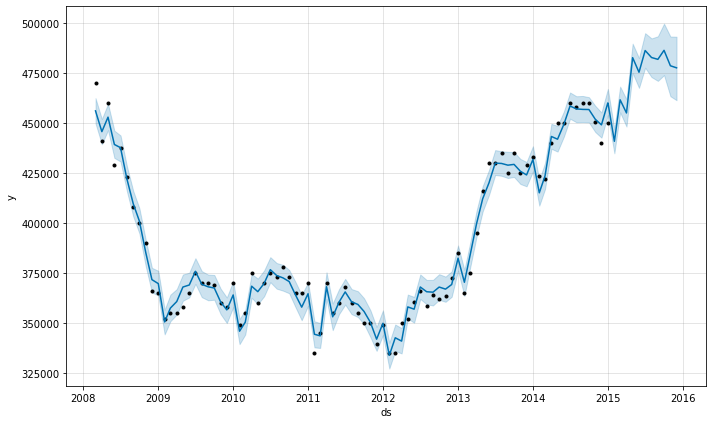

In [52]:
# m = Prophet(seasonality_mode='multiplicative')
m = Prophet()

# m.add_regressor('UnemploymentRate')
m.add_regressor('MedianMortageRate')
m.fit(train_df)

future = m.make_future_dataframe(periods=prediction_size, freq='MS')
future['MedianMortageRate'] = dt2['MedianMortageRate'].values
# future['UnemploymentRate'] = dt2['UnemploymentRate'].values
forecast = m.predict(future)
m.plot(forecast).show()

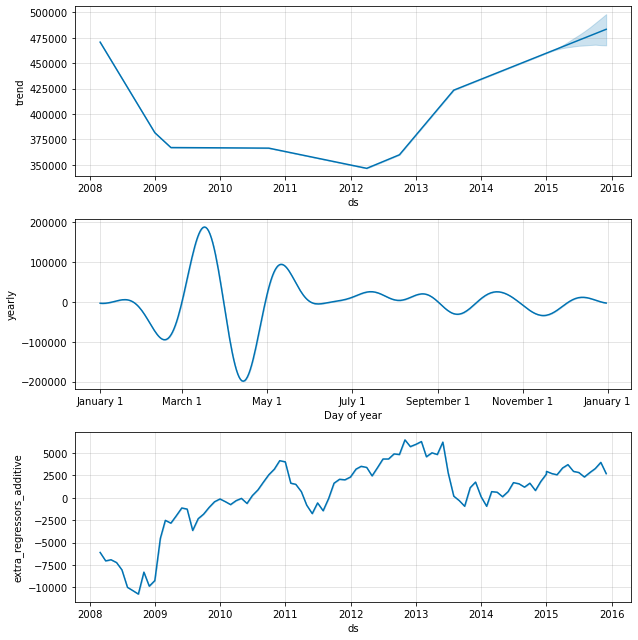

In [53]:
m.plot_components(forecast).show()

In [54]:
pred = forecast["yhat"][train_df.shape[0]:]

In [55]:
multi_prophet_rmse = mean_squared_error(val_df['y'], pred, squared=False)
print(multi_prophet_rmse)

9858.865380123276


 - dt_rmse = 14292.82195 # Unemployment Rate as regressor
 - dt2_rmse = 9858.86538 # Median Morgage Rate as regressor
 - dt3_rmse = 13124.48921 # Both as regressors

### SARIMAX

In [56]:
zillow = pd.read_csv('zillow-carlifornia.csv', index_col=[0])
df = zillow[:'2015-12-31']

prediction_size=12
train = df[:-prediction_size]
valid = df[-prediction_size:]
# train_df.head()
# train_df.tail()

In [57]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
train_sc = sc.fit_transform(train)
test_sc = sc.transform(valid)
from pmdarima.arima import auto_arima
model=auto_arima(train_sc[:,0], # gdp as endogenous
                 exogenous= train_sc[:,1:], # rest as exogenous
                 start_p=0, start_q=0,
                 max_p=4, max_q=4, 
                 max_d=2,
                 m=12, D=1, max_P=3, max_Q=3,
                 trace=True,
                 error_action='ignore',
                 with_intercept=True,
                 suppress_warnings=True,
                 information_criterion='oob',
                 n_jobs = -1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12] intercept   : AIC=-147.088, Time=0.58 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=-144.484, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   : AIC=-148.827, Time=0.31 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=-149.683, Time=0.53 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-144.310, Time=0.12 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=-145.555, Time=0.19 sec
 ARIMA(0,1,1)(1,1,1)[12] intercept   : AIC=-148.768, Time=0.66 sec
 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=inf, Time=1.26 sec
 ARIMA(0,1,1)(1,1,0)[12] intercept   : AIC=-145.893, Time=0.40 sec
 ARIMA(0,1,1)(1,1,2)[12] intercept   : AIC=-148.932, Time=1.48 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=-145.127, Time=0.35 sec
 ARIMA(1,1,1)(0,1,1)[12] intercept   : AIC=-154.120, Time=0.63 sec
 ARIMA(1,1,1)(0,1,0)[12] intercept   : AIC=-146.630, Time=0.37 sec
 ARIMA(1,1,1)(1,1,1)[12] intercept   : AIC=-143.681, Time=0.79 sec
 ARIMA(1,1,1)(0,1,2)[12]

In [58]:
y_pred = model.predict(n_periods=prediction_size,X=test_sc[:,1:]).reshape(-1,1)
y_pred_ = np.repeat(y_pred,3,axis=1)
y_pred_inv = sc.inverse_transform(y_pred_)[:,0]# inverset the pred and take the first column (gdp)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


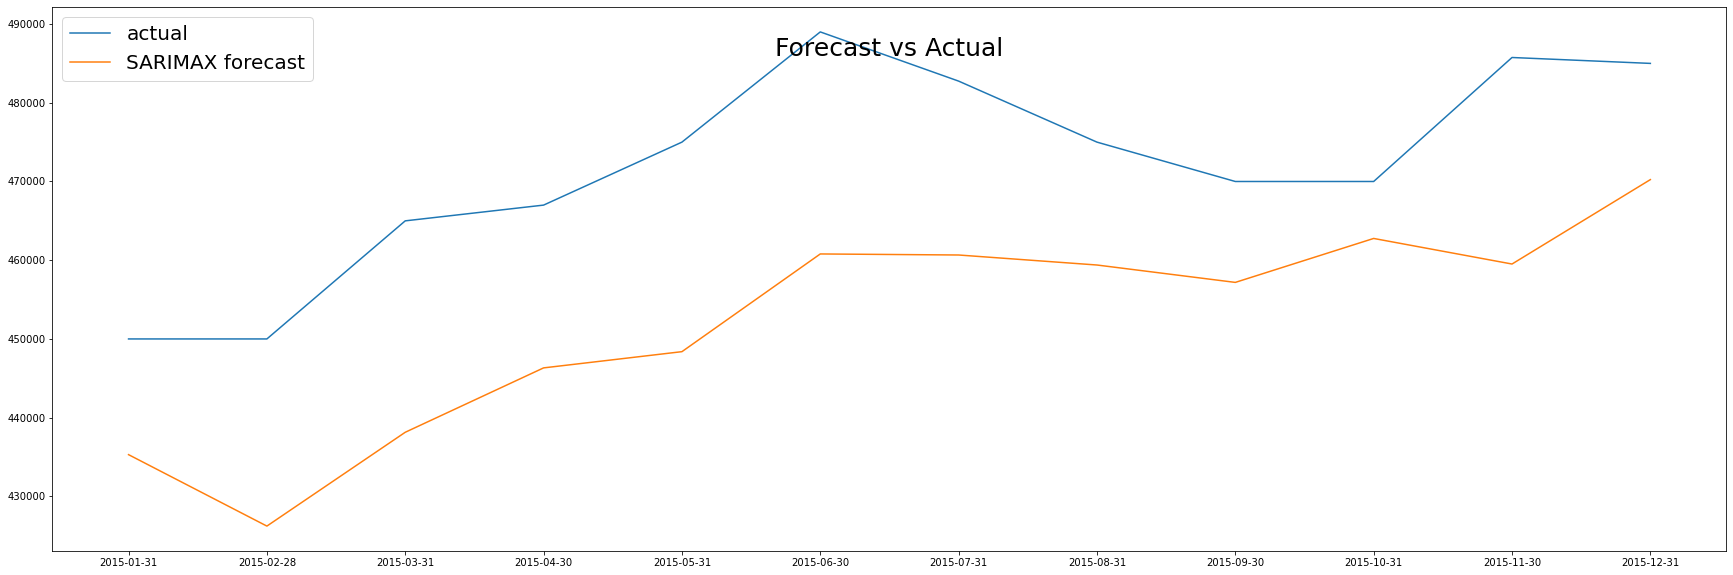

In [59]:
y_pred_series = pd.Series(y_pred_inv,index=valid.index)
plt.figure(figsize=(30, 10))

plt.plot(valid['MedianSoldPrice_AllHomes.California'], label='actual')
plt.plot(y_pred_series, label='SARIMAX forecast')
plt.legend(loc='upper left', fontsize=20)
plt.title('Forecast vs Actual', fontsize = 25, y = 0.9)
plt.show()

In [60]:
sarimax_rmse = mean_squared_error(y_pred_series, valid['MedianSoldPrice_AllHomes.California'], squared=False)
print(sarimax_rmse)

20992.153734202082


### LSTM

In [61]:
values = df[['MedianSoldPrice_AllHomes.California', 'UnemploymentRate']].values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1) 
#print(reframed.head())
reframed.drop(reframed.columns[[-1]], axis=1, inplace=True)
#print(reframed.head())
values = reframed.values
period=12
train = values[:-period, :]
test = values[-period:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(10, input_shape=(train_X.shape[1], train_X.shape[2]))) # the 4 is the number of hidden layers/neurons, proportional to the sample size
model.add(Dense(1)) #final fully-connected (dense) layer, optional
model.compile(loss='mse')
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=7, validation_data=(test_X, test_y))

Epoch 1/200
12/12 [==============================] - 2s 47ms/step - loss: 0.1978 - val_loss: 0.7661
Epoch 2/200
12/12 [==============================] - 0s 3ms/step - loss: 0.1615 - val_loss: 0.6968
Epoch 3/200
12/12 [==============================] - 0s 3ms/step - loss: 0.1557 - val_loss: 0.6359
Epoch 4/200
12/12 [==============================] - 0s 4ms/step - loss: 0.1251 - val_loss: 0.5750
Epoch 5/200
12/12 [==============================] - 0s 3ms/step - loss: 0.1334 - val_loss: 0.5235
Epoch 6/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0960 - val_loss: 0.4710
Epoch 7/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0696 - val_loss: 0.4232
Epoch 8/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0647 - val_loss: 0.3817
Epoch 9/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0656 - val_loss: 0.3427
Epoch 10/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0500 - val_loss: 0.3064
Epoch 11

In [62]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

multi_lstm_rmse = mean_squared_error(np.array(inv_y), np.array(inv_yhat),squared=False)
print(multi_lstm_rmse)

18568.112452051344


In [74]:
print('Univariate: ')
print(f'SARIMA:  {sarima_rmse1:.4f}')
print(f'ETS:     {ets_rmse_3:.4f}')
print(f'Prophet: {prophet_rmse:.4f}')
print(f'LSTM:    {lstm_rmse:.4f}')
print()
print('Multivariate: ')
print(f'Prophet: {multi_prophet_rmse:.4f}') 
print(f'SARIMAX: {sarimax_rmse:.4f}')
print(f'LSTM:    {multi_lstm_rmse:.4f}')


Univariate: 
SARIMA:  9945.0574
ETS:     9224.3898
Prophet: 9328.9186
LSTM:    10019.1377

Multivariate: 
Prophet: 9858.8654
SARIMAX: 20992.1537
LSTM:    18568.1125


In [64]:
#testing model on test.csv
test = pd.read_csv('test.csv', index_col=[0])
print(test)

            Median House Price
Month                         
2016-01-31              476250
2016-02-29              466000
2016-03-31              485000
2016-04-30              501000
2016-05-31              501000
2016-06-30              505000
2016-07-31              507000
2016-08-31              510000
2016-09-30              510000
2016-10-31              523000
2016-11-30              506000
2016-12-31              510000


In [65]:
len(df)

95

In [93]:
# Fit best model on entire train data and then forecast
# ets_rmse_3=evaluate_es_model(X, Trend="additive", Seasonal="multiplicative",m=12,damped=True)

Trend = 'additive'
Seasonal = "multiplicative"
m = 12
Damped = True
X=np.array(df['MedianSoldPrice_AllHomes.California'])+1 #adding 1 to avoide 0 sales 
best_model_ets=ExponentialSmoothing(X, trend=Trend, seasonal=Seasonal, damped=Damped, seasonal_periods=m)
pred_best_ets=best_model_ets.fit().forecast(len(test))
pred_best_ets

array([447656.24341923, 467197.69751926, 518649.85117029, 565886.63871392,
       613035.17004221, 654706.41976962, 655672.83966765, 635463.69282566,
       601670.8473773 , 558592.08922585, 525663.26809932, 453999.24338505])

In [94]:
test.columns

Index(['Median House Price', 'pred'], dtype='object')

In [95]:
test.shape, pred_best_ets.shape

((12, 2), (12,))

In [96]:
mean_squared_error(test['pred'], pred_best_ets, squared=False)

95022.4203870787

In [97]:
mean_absolute_percentage_error(test['pred'],pred_best_ets)

0.16223758595236623

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

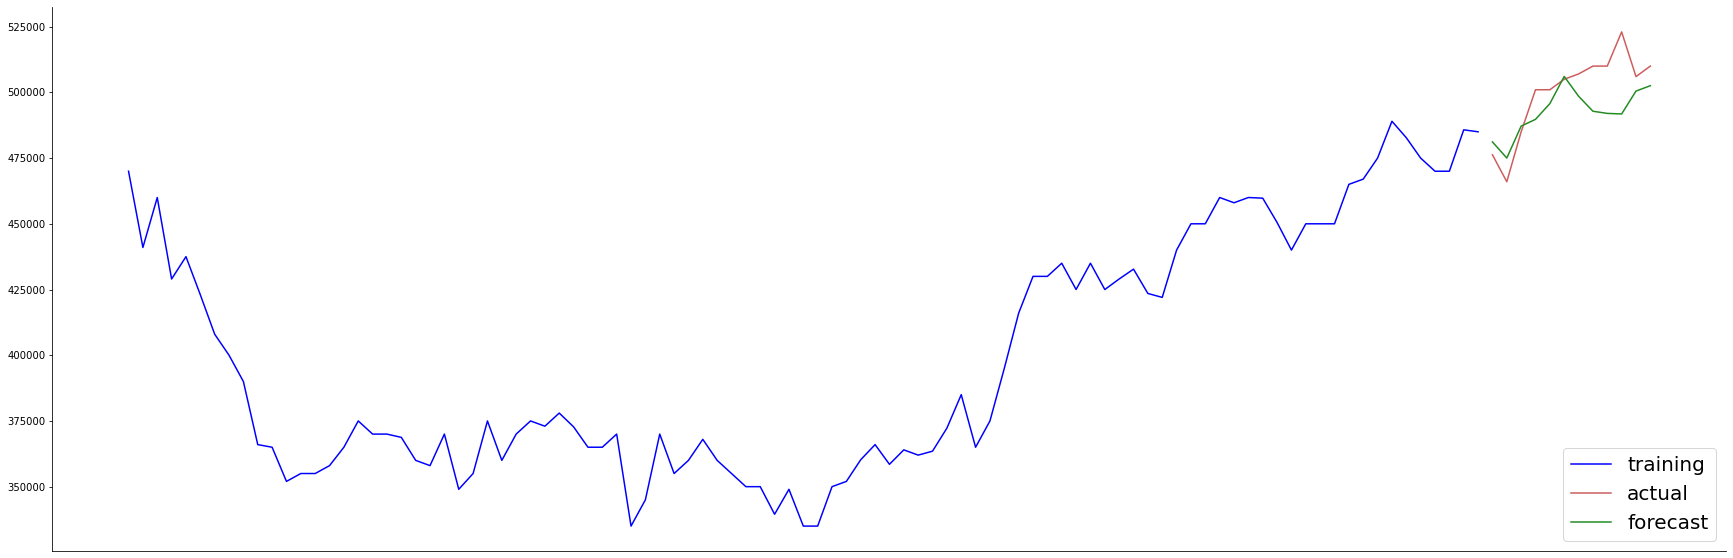

In [88]:
test['pred'] = pred_best_ets
fig, ax = plt.subplots(figsize=(30, 10))
ax.plot(df['MedianSoldPrice_AllHomes.California'], label='training', color='blue')
ax.plot(test['Median House Price'], label='actual', color='indianred')
ax.plot(test['pred'], label='forecast', color='forestgreen')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(loc='lower right', fontsize=20)
plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
#plt.locator_params(nbins=10)
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


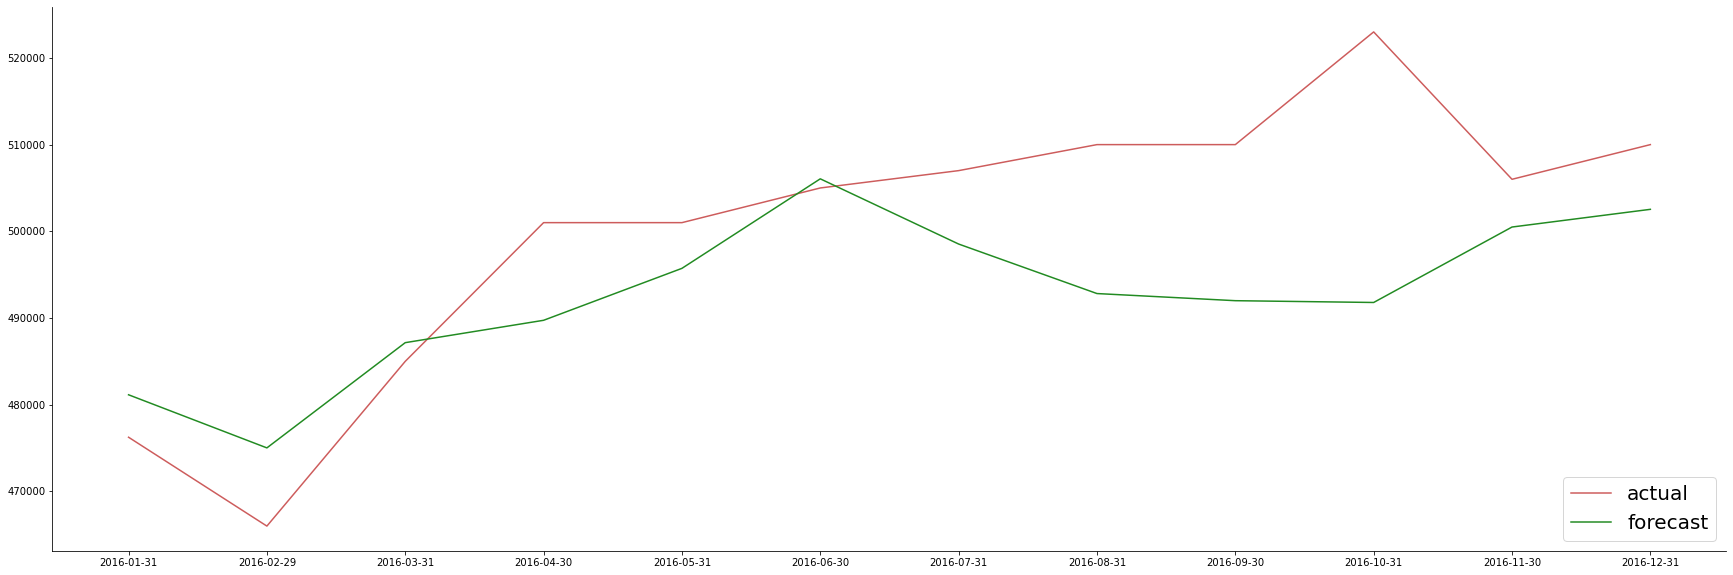

In [89]:
fig, ax = plt.subplots(figsize=(30,10))


ax.plot(test['Median House Price'], label='actual', color='indianred')
ax.plot(test['pred'], label='forecast', color='forestgreen')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(loc='lower right', fontsize=20)
plt.show()

In [90]:
print(test)

            Median House Price           pred
Month                                        
2016-01-31              476250  481146.474895
2016-02-29              466000  475019.569629
2016-03-31              485000  487157.205814
2016-04-30              501000  489736.518213
2016-05-31              501000  495728.091443
2016-06-30              505000  506054.070340
2016-07-31              507000  498533.043246
2016-08-31              510000  492821.607282
2016-09-30              510000  491998.573705
2016-10-31              523000  491791.798511
2016-11-30              506000  500494.230977
2016-12-31              510000  502535.836932


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5e9f19dd-fe63-47e4-96ab-256312edafbe' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>